In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

In [2]:
df = pd.read_csv('data/zillow_data.csv')
lumber = pd.read_csv('data/plywood_prices.csv')
concrete = pd.read_csv('data/concrete_prices.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
lumber.rename({'WPU083': 'plywood prices', 'DATE': 'time'}, axis=1, inplace=True)
lumber

,time,plywood prices
0,2003-12-01,192.1
1,2004-01-01,174.4
2,2004-02-01,202.5
3,2004-03-01,218.5
4,2004-04-01,222.6
...,...,...
168,2017-12-01,218.1
169,2018-01-01,219.8
170,2018-02-01,227.9
171,2018-03-01,236.5


In [4]:
concrete.rename({'PCU32733273': 'concrete prices', 'DATE' : 'time'}, axis = 1, inplace = True)
concrete

,time,concrete prices
0,2003-12-01,100.0
1,2004-01-01,100.9
2,2004-02-01,101.7
3,2004-03-01,101.7
4,2004-04-01,102.4
...,...,...
168,2017-12-01,164.3
169,2018-01-01,165.8
170,2018-02-01,166.1
171,2018-03-01,168.9


In [5]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [6]:
def melt_data(df, compress = False):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    
    If compress is True will compress data to only the value column.
    """
    if compress == True:
        melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                      'Metro', 'CountyName'], var_name='time')
        melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
        melted = melted.dropna(subset=['value'])
        return melted.groupby('time').aggregate({'value':'mean'})
    else:
        melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                      'Metro', 'CountyName'], var_name='time')
        melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
        melted = melted.dropna(subset=['value'])
        return melted

In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Takes in the y_true values and the y_pred and will
    return the mean absolute error as a percent
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
def plot_series(df, name = None, window = None, X = None, y = None, x_label = None, y_label = None):
    '''
    Will plot dataframe, rolling mean, rolling std of a given dataframe
    
    Parameters
    ------------
    df : The dataframe you with to plot
    name : The name of the plot
    window : The window of the rolling values
    X : length of the df
    y : height of the df
    x_label : The X-axis label
    y_label : The y-axis label
    
    Returns
    -----------
    Plot of the Original data, the rolling mean, and the rolling standard deviation
    '''
    df_mean = df.rolling(window=window).mean()
    df_std = df.rolling(window=window).std()

    fig, ax = plt.subplots(figsize = (X,y))

    orig = plt.plot(df, label = 'Original')
    mean = plt.plot(df_mean, label = 'Rolling Mean')
    std = plt.plot(df_std, label = 'Rolling Std')
    plt.title(name)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc = 'best')
    plt.show();

In [9]:
def seasonal_plot(df, window = None, X = None, y = None):
    '''
    Plotting the seasonal decompose
    
    Parameters
    -----------
    df : The dataframe you wish to decompose
    window : The rolling window
    X : The length of the plot
    y : The Height of the plot
    
    Return 
    -----------
    A seasonal decompose of the dataframe. 
    '''
    result = seasonal_decompose(df.rolling(window).mean().dropna())
    plt.rcParams['figure.figsize'] = (X,y)
    result.plot();

In [10]:
def adfuller_test(df, name = None):
    '''
    Take a dataframe or series and returns the adfuller test for it.
    
    Parameters
    -----------
    df : dataframe or series
    name = Name of the variable you are testing
    '''
    df_test = adfuller(df)
    print(f'Adfuller test for {name}')
    print('-'*20)
    print('Test Stastic = {:.3f}'.format(df_test[0]))
    print('P-value = {:.3f}'.format(df_test[1]))
    print('Critical values :')
    for k, v in df_test[4].items():
        print(f"{k}: {v} - The data is {'not' if v < df_test[0] else ''} stationary with {100 - int(k[:-1])}% confidence")

In [11]:
def kpss_test(df, name = None):
    '''
    Will return the kpss test
    
    Parmeters
    ----------
    df = dataframe or series
    name = Name of the variable you are testing
    '''
    df_test = kpss(np.log(df), nlags='auto')
    print(f'Is {name} data stationary?')
    print(f'Test stastic = {df_test[0]: .3f}')
    print(f'P-value = {df_test[1]: .3f}')
    print('Critical Values: ')
    for k, v in df_test[3].items():
        print(f'{k}: {v}')

In [12]:
df_melt = melt_data(df)
df_melt.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,60657,84654,1,Chicago,IL,Chicago,Cook,1996-04-01,334200.0
1,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0
2,77494,91982,3,Katy,TX,Houston,Harris,1996-04-01,210400.0
3,60614,84616,4,Chicago,IL,Chicago,Cook,1996-04-01,498100.0
4,79936,93144,5,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0


In [13]:
df_melt.tail()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
3901590,1338,58333,14719,Ashfield,MA,Greenfield Town,Franklin,2018-04-01,209300.0
3901591,3293,59107,14720,Woodstock,NH,Claremont,Grafton,2018-04-01,225800.0
3901592,40404,75672,14721,Berea,KY,Richmond,Madison,2018-04-01,133400.0
3901593,81225,93733,14722,Mount Crested Butte,CO,NaN,Gunnison,2018-04-01,664400.0
3901594,89155,95851,14723,Mesquite,NV,Las Vegas,Clark,2018-04-01,357200.0


In [14]:
df_melt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionName  int64         
 1   RegionID    int64         
 2   SizeRank    int64         
 3   City        object        
 4   State       object        
 5   Metro       object        
 6   CountyName  object        
 7   time        datetime64[ns]
 8   value       float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 285.7+ MB


In [15]:
df_melt.time.min(), df_melt.time.max()

(Timestamp('1996-04-01 00:00:00'), Timestamp('2018-04-01 00:00:00'))

#### HOLD

In [16]:
melt_df= melt_data(df, compress=False)

In [17]:
melt_df.set_index('time', inplace=True)

In [18]:
melt_df = melt_df[melt_df.index >= '2003-12-01']

In [19]:
melt_df

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value
time,,,,,,,,
2003-12-01,60657,84654,1,Chicago,IL,Chicago,Cook,752300.0
2003-12-01,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,187100.0
2003-12-01,77494,91982,3,Katy,TX,Houston,Harris,229600.0
2003-12-01,60614,84616,4,Chicago,IL,Chicago,Cook,1012600.0
2003-12-01,79936,93144,5,El Paso,TX,El Paso,El Paso,83400.0
...,...,...,...,...,...,...,...,...
2018-04-01,1338,58333,14719,Ashfield,MA,Greenfield Town,Franklin,209300.0
2018-04-01,3293,59107,14720,Woodstock,NH,Claremont,Grafton,225800.0
2018-04-01,40404,75672,14721,Berea,KY,Richmond,Madison,133400.0


In [20]:
try:
    lumber.set_index('time', inplace=True)
except:
    pass
lumber

,plywood prices
time,
2003-12-01,192.1
2004-01-01,174.4
2004-02-01,202.5
2004-03-01,218.5
2004-04-01,222.6
...,...
2017-12-01,218.1
2018-01-01,219.8
2018-02-01,227.9


In [21]:
try:
    concrete.set_index('time', inplace=True)
except:
    pass
concrete

,concrete prices
time,
2003-12-01,100.0
2004-01-01,100.9
2004-02-01,101.7
2004-03-01,101.7
2004-04-01,102.4
...,...
2017-12-01,164.3
2018-01-01,165.8
2018-02-01,166.1


In [22]:
try:
    con_lum = pd.concat([concrete, lumber], axis=1)
except:
    pass
con_lum.sample(50)

,concrete prices,plywood prices
time,,
2014-05-01,146.3,200.9
2009-09-01,136.8,166.7
2006-04-01,125.7,182.4
2015-04-01,154.0,203.4
2016-05-01,158.6,191.0
2015-02-01,152.2,202.8
2005-01-01,110.3,187.0
2013-03-01,140.2,204.7
2008-05-01,136.0,177.8


In [23]:
try:
    con_lum.index = pd.to_datetime(con_lum.index)
except:
    pass
con_lum

,concrete prices,plywood prices
time,,
2003-12-01,100.0,192.1
2004-01-01,100.9,174.4
2004-02-01,101.7,202.5
2004-03-01,101.7,218.5
2004-04-01,102.4,222.6
...,...,...
2017-12-01,164.3,218.1
2018-01-01,165.8,219.8
2018-02-01,166.1,227.9


In [24]:
final_df = pd.concat([melt_df, con_lum], axis=1)
final_df

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value,concrete prices,plywood prices
time,,,,,,,,,,
2003-12-01,60657,84654,1,Chicago,IL,Chicago,Cook,752300.0,100.0,192.1
2003-12-01,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,187100.0,100.0,192.1
2003-12-01,77494,91982,3,Katy,TX,Houston,Harris,229600.0,100.0,192.1
2003-12-01,60614,84616,4,Chicago,IL,Chicago,Cook,1012600.0,100.0,192.1
2003-12-01,79936,93144,5,El Paso,TX,El Paso,El Paso,83400.0,100.0,192.1
...,...,...,...,...,...,...,...,...,...,...
2018-04-01,1338,58333,14719,Ashfield,MA,Greenfield Town,Franklin,209300.0,169.0,236.6
2018-04-01,3293,59107,14720,Woodstock,NH,Claremont,Grafton,225800.0,169.0,236.6
2018-04-01,40404,75672,14721,Berea,KY,Richmond,Madison,133400.0,169.0,236.6


# TIme Series Analysis

In [25]:
Denver_df = final_df[final_df['RegionName'] == 80216]
Vallejo_df = final_df[final_df['RegionName'] == 94590]
Atlanta_df = final_df[final_df['RegionName'] == 30316]
Miami_gard_df = final_df[final_df['RegionName'] == 33055]
Miami_df = final_df[final_df['RegionName'] == 33135]

### Denver

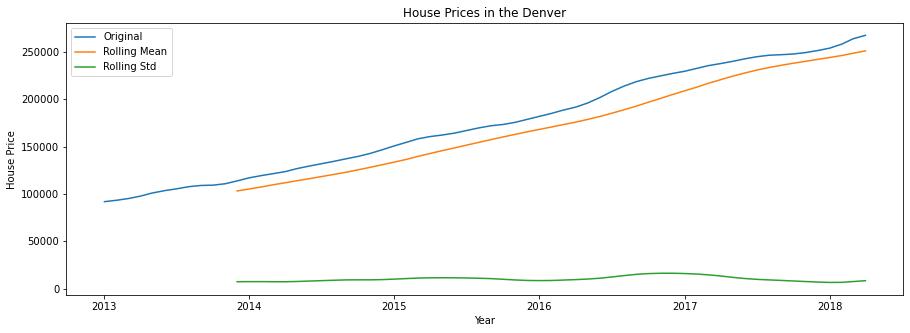

In [26]:
denver = Denver_df[['value']]
plot_series(denver, name='House Prices in the Denver', window=12,
            X = 15,
            y = 5,
            x_label= 'Year',
            y_label='House Price')

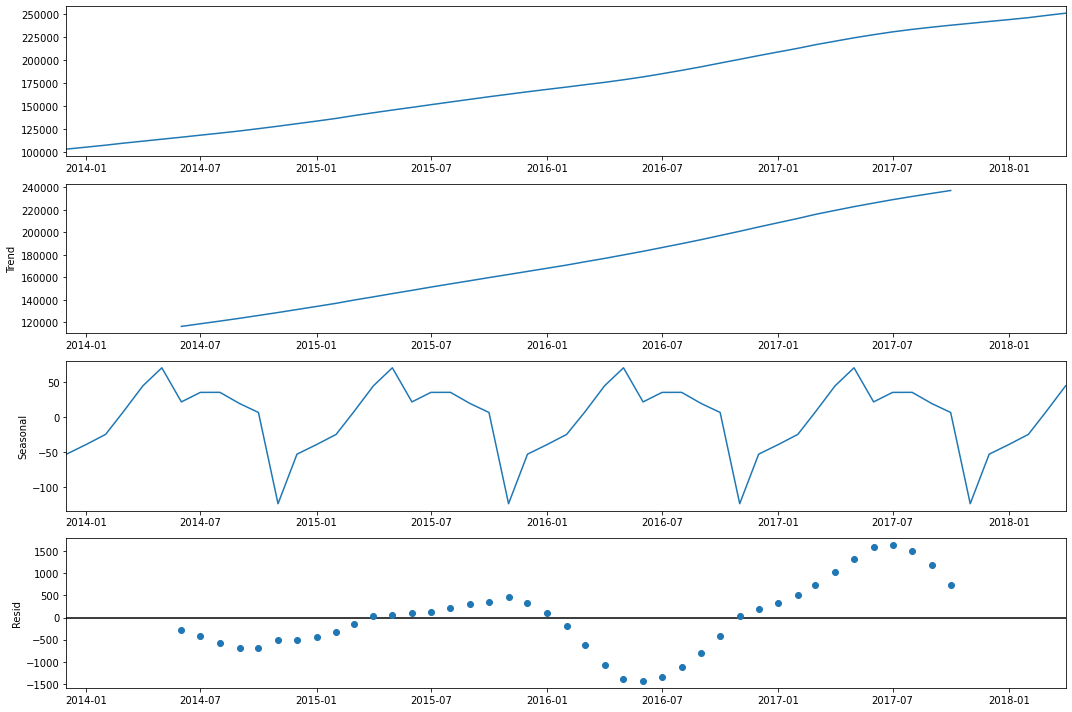

In [27]:
seasonal_plot(denver, window=12, X = 15, y = 10)

In [28]:
adfuller_test(denver, name='Denver Prices')

Adfuller test for Denver Prices
--------------------
Test Stastic = 0.221
P-value = 0.973
Critical values :
1%: -3.5443688564814813 - The data is not stationary with 99% confidence
5%: -2.9110731481481484 - The data is not stationary with 95% confidence
10%: -2.5931902777777776 - The data is not stationary with 90% confidence


In [29]:
kpss_test(denver, name = 'Denver Prices')

Is Denver Prices data stationary?
Test stastic =  1.167
P-value =  0.010
Critical Values: 
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [30]:
Denver_lstm = Denver_df.drop(['RegionName', 'RegionID', 'SizeRank', 'City', 'Metro', 'CountyName', 'State'], axis=1)
Denver_lstm.reset_index(inplace=True)
train_dates = Denver_lstm.time
cols = list(Denver_lstm)[1:]
denver_for_train = Denver_df[cols].astype(float)
scaler = StandardScaler()
denver_for_train_scaled = scaler.fit_transform(denver_for_train)

trainX = []
trainY = []

n_future = 1
n_past = 6

for i in range(n_past, len(denver_for_train_scaled) - n_future + 1):
    trainX.append(denver_for_train_scaled[i - n_past:i, 0:denver_for_train.shape[1]])
    trainY.append(denver_for_train_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
print(f'trainX shape == {trainX.shape}')
print(f'trainY shape == {trainY.shape}')

trainX shape == (58, 6, 3)
trainY shape == (58, 1)


In [31]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation = 'relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss = 'mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 64)             17408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(trainX, trainY, epochs=50, batch_size = 5, validation_split=.1, verbose = 0, use_multiprocessing=True)

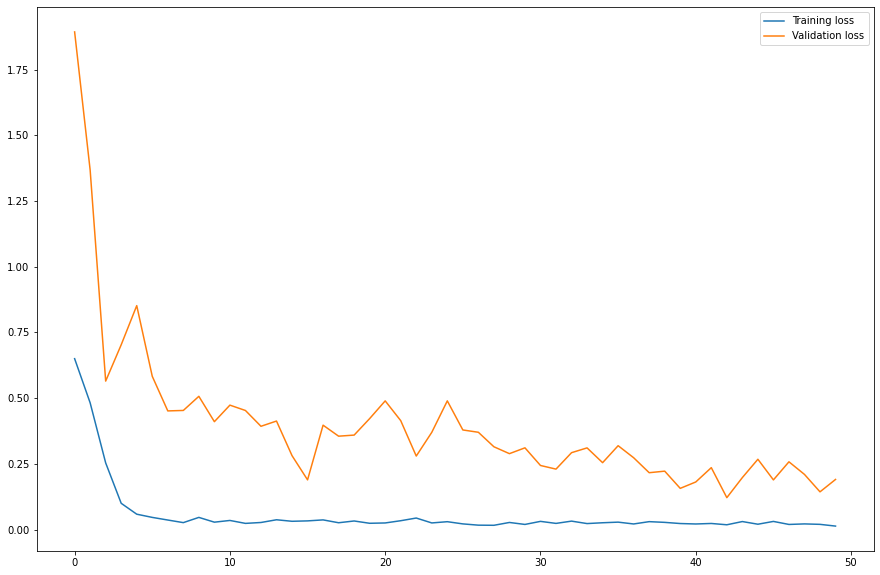

In [33]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend();

In [34]:
len(train_dates)

64

In [35]:
len(Denver_lstm)

64

In [36]:
len(y_pred_future)

NameError: name 'y_pred_future' is not defined

In [ ]:
len(forecast_dates)

In [ ]:
future_val = 58
forecast_period_dates = pd.date_range(list(train_dates)[0], periods=future_val, freq='MS').to_list()
forecast = model.predict(trainX[-future_val:])

forecast_copies = np.repeat(forecast, denver_for_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'time' : np.array(forecast_dates), 'value': y_pred_future})
df_forecast['time'] = pd.to_datetime(df_forecast['time'])

original = Denver_lstm[['time', 'value']]

In [ ]:
sns.lineplot(original['time'], original['value'])
sns.lineplot(df_forecast['time'], df_forecast['value']);

### Vallejo

In [ ]:
Vallejo = Vallejo_df[['value']]
plot_series(Vallejo, name = 'House Prices in Vallejo',
            window=12,
            X = 15, y = 5,
            x_label= 'Year',
            y_label= 'House Prices')

In [ ]:
seasonal_plot(Vallejo, window=13, X = 15, y = 10)

In [ ]:
adfuller_test(Vallejo, 'Vallejo Prices')

In [ ]:
kpss_test(Vallejo, 'Vallejo Prices')

### Atlanta

In [ ]:
Atlanta = Atlanta_df[['value']]
plot_series(Atlanta, name = 'House Prices in Atlanta',
            window=12,
            X= 15, y = 5,
            x_label= 'Year',
            y_label= 'House Prices')

In [ ]:
seasonal_plot(Atlanta, window=12, X = 15, y = 10)

In [ ]:
adfuller_test(Atlanta, 'Atlanta Prices')

In [ ]:
kpss_test(Atlanta, 'Atlanta Prices')

### Miami Gardens

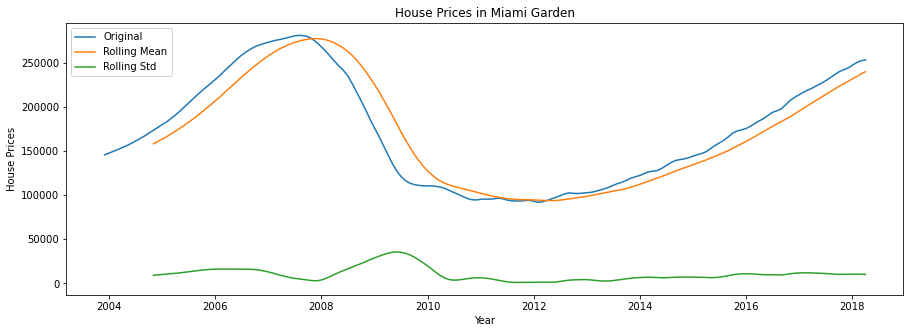

In [63]:
Miami_gard = Miami_gard_df[['value']]
plot_series(Miami_gard, name = 'House Prices in Miami Garden',
            X = 15,
            y = 5,
            x_label= 'Year',
            y_label='House Prices',
            window = 12)

In [ ]:
seasonal_plot(Miami_gard, window=12, X = 15, y = 10)

In [ ]:
adfuller_test(Miami_gard, name = 'Miami Garden Prices')

In [ ]:
kpss_test(Miami_gard, name = 'Miami Garden Prices')

### Miami

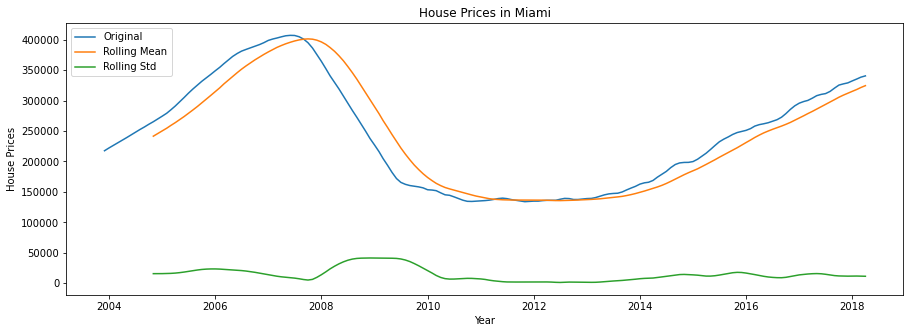

In [87]:
Miami = Miami_df[['value']]
plot_series(Miami, name = 'House Prices in Miami', window=12, X = 15, y = 5, x_label= 'Year', y_label= 'House Prices')

In [ ]:
seasonal_plot(Miami, window=12, X = 15, y = 10)

In [ ]:
adfuller_test(Miami, name = 'Miami Prices')

In [ ]:
kpss_test(Miami, name = 'Miami Prices')

## Cross Validation

In [96]:
def rmse(y_true, y_pred):
    sum_squared_diff = sum([(y2 - y1)**2 for y2,y1 in zip(y_true, y_pred)])
    rmse = (sum_squared_diff * (1/len(y_true))) ** 0.5
    return rmse

def cross_validate(model, df, split_freq='D', model_kwargs={}):
    '''
    model: uninitalized model- no parantheses 
    '''
   
    df = df.resample('M').mean()
   
    split = TimeSeriesSplit(n_splits=2)

    all_rmse = []
    for train_ind, val_ind in split.split(df):
        model_fit = model(df.iloc[train_ind, -1], **model_kwargs).fit()
        preds = model_fit.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
        true = df.iloc[val_ind, -1]
        all_rmse.append(rmse(true, preds))
   
cross_validate(ARIMA, Miami, 'M', model_kwargs={'order':(1,2,0)})

## Arima 

In [59]:
def arima(series, order):
    '''
    order = (p,d,q)
    p: The number of lag observations included in the model, also called the lag order.
    d: The number of times that the raw observations are differenced, also called the degree of differencing.
    q: The size of the moving average window, also called the order of moving average
    '''
    model = ARIMA(series.values, order=order).fit()
    print(model.summary())
    
    residuals = model.resid
    fig, ax = plt.subplots()
    ax.plot(series.index, residuals)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  173
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1446.017
Date:                Mon, 23 Aug 2021   AIC                           2896.033
Time:                        10:05:06   BIC                           2902.316
Sample:                             0   HQIC                          2898.583
                                - 173                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0127      0.015      0.845      0.398      -0.017       0.042
sigma2      1.143e+06   9.77e+04     11.698      0.000    9.51e+05    1.33e+06
Ljung-Box (L1) (Q):                  20.06   Jarque-

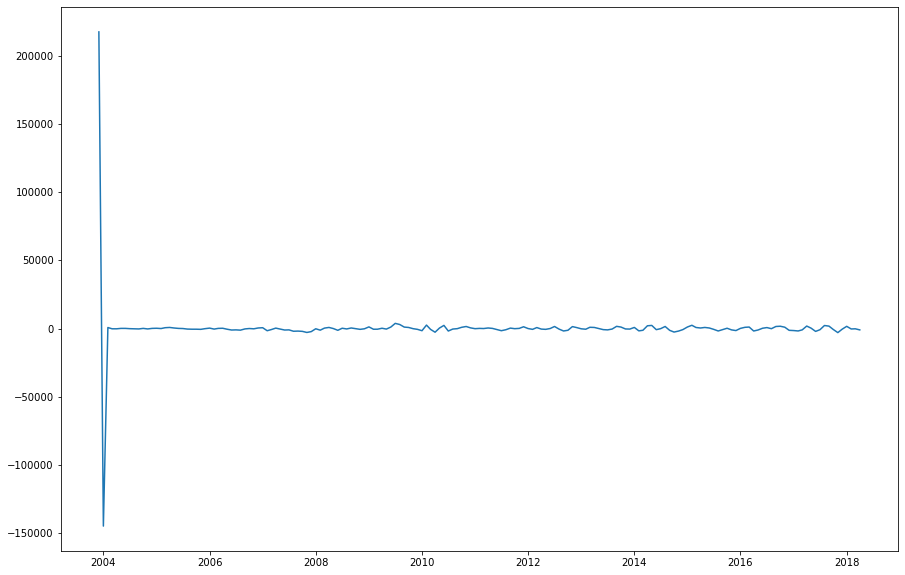

In [62]:
arima(Miami, (1,2,0))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  173
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1446.017
Date:                Mon, 23 Aug 2021   AIC                           2896.033
Time:                        10:13:57   BIC                           2902.316
Sample:                             0   HQIC                          2898.583
                                - 173                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0127      0.015      0.845      0.398      -0.017       0.042
sigma2      1.143e+06   9.77e+04     11.698      0.000    9.51e+05    1.33e+06
Ljung-Box (L1) (Q):                  20.06   Jarque-

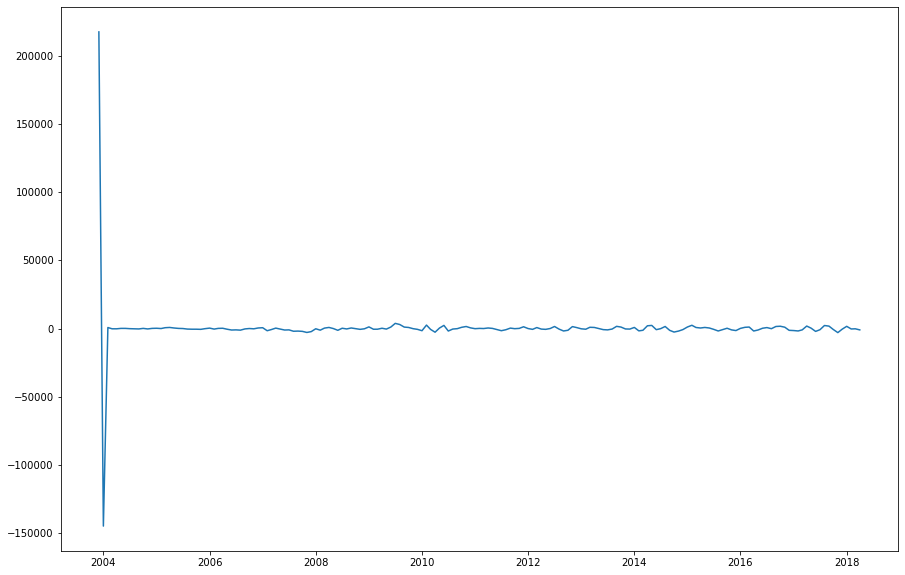

In [66]:
arima(Miami_gard, (1,2,0))